**Table of contents**<a id='toc0_'></a>    
- [Master Structure POC](#toc1_)       
  - [I: Introduction](#toc1_2_)    
    - [The Concept](#toc1_2_1_)     
  - [II. Identify Relationship Between Sources](#toc1_3_)    
    - [Create Sources and Sttructures](#toc1_3_1_)    
      - [Step 1: Create geodf of each source](#toc1_3_1_1_)    
      - [Step 2: Calculate area of intersection](#toc1_3_1_2_)    
      - [Step 3: ](#toc1_3_1_3_)    
      - [Step 4: ](#toc1_3_1_4_)    
      - [Step 5: Clustering the Data](#toc1_3_1_5_)    
      - [Understanding The Variables](#toc1_3_1_6_)    
  - [III. Results](#toc1_4_)    
  - [IV. Cross-Region Clustering](#toc1_5_)    
    - [Step 1: Identify Single Parcels within the Optimal Distance](#toc1_5_1_)    
    - [Step 2: Identify Same-Owner Clusters in different regions within the Optimal Distance](#toc1_5_2_)    
    - [Step 3: Dissolve and Reverse Buffer](#toc1_5_3_)    
  - [V. Cross-Region Clustering Results](#toc1_6_)    
      - [Final Thoughts:](#toc1_6_1_1_)    

<!-- vscode-jupyter-toc-config
    numbering=false
    anchor=true
    flat=false
    minLevel=1
    maxLevel=6
    /vscode-jupyter-toc-config -->





# <a id='toc1_'></a>[Master Structure POC](#toc0_)
## <a id='toc1_1_'></a>[I. Introduction](#toc0_)
### <a id='toc1_2_1_'></a>[The Concept](#toc0_)
Establish a data asset for structure footprints nationwide, where each structure record is identified by a unique persistent identifier (structure ID). The structure ID for a given structure stays teh same across multiple vintages. The structure ID ties together multiple sources of structure footprints. Demolished structures are retained with inactive status.


In [1]:
import pandas as pd
import geopandas as gpd
import db_dtypes
import matplotlib.pyplot as plt 
import folium
from shapely.geometry import Point, Polygon, LineString
from shapely import intersection
%matplotlib inline

## <a id='toc1_1_'></a>[II. Identify Relationships Between Sources](#toc0_)
### <a id='toc1_2_1_'></a>[Create Sources and Structures](#toc0_)
#### <a id='toc1_2_1_'></a>[Step1: Create geodataframe of each source](#toc0_)

In [78]:
# create a simple polygons that represent strctures for source 1
p1 = Polygon([(0, 0), (1, 0), (1.5, 0.5), (1, 1), (0, 1)])
p2 = Polygon([(5,0), (5,2), (3,2), (3,0)])
p3 = Polygon([(0,2), (2,2), (2,4), (0,4)]) 
p4 = Polygon([(3,2.5),(4,2.5),(4,4),(3,4)])
p5 = Polygon([(6,1),(7,1),(7,3), (6,3)])
p10 = Polygon([(4.5,3), (5.5,3), (5.5,5), (4.5,5)])

attribs = {'id': ['A', 'B', 'C', 'D','E','J'], 'source': ['1','1','1','1','1','1']}

In [100]:
# create a simple polygons that represent strctures for source 2
p6 = Polygon([(0, 0), (2, 0), (2.0,1.0), (0.5, 1.0)])
p7 = Polygon([(0,2.5), (2,2.5), (2,4), (0,4)])
p8 = Polygon([(5,0), (5,3.75), (3,3.75), (3,0)])
p9 = Polygon([(7,0), (8,0), (8,4), (7,4)])


attribs2 = {'id': ['F','G','H','I'], 'source': ['2','2','2','2']}

In [102]:
g = gpd.GeoDataFrame(attribs, geometry=[p1,p2,p3,p4,p5,p10])
g2 = gpd.GeoDataFrame(attribs2, geometry=[p6,p7,p8,p9])

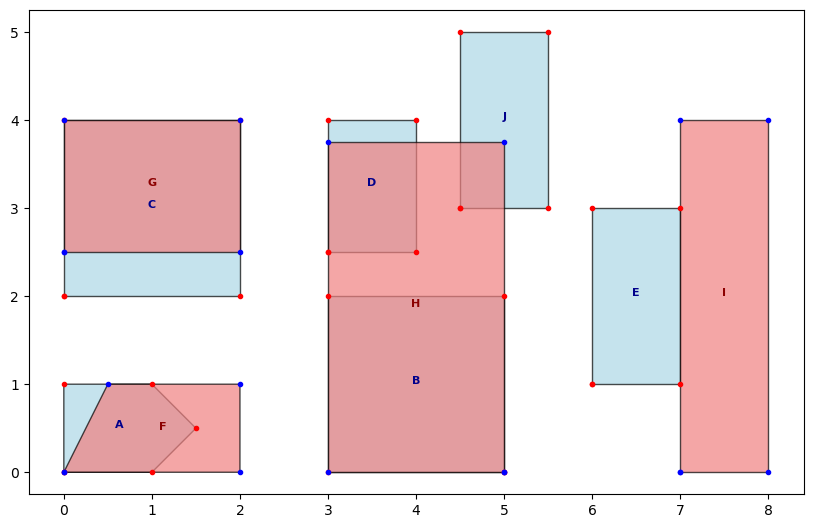

In [103]:
# visualize all polygons with their owner values
fig, ax = plt.subplots(figsize=(10, 10))
g.plot(ax=ax, edgecolor='black', facecolor='lightblue', alpha =0.7)
g2.plot(ax=ax, edgecolor='black', facecolor='lightcoral', alpha =0.7)   

# Annotating each polygon with the 'owner' value at its centroid
for idx, row in g.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['id'], horizontalalignment='center', fontsize=8, weight='bold', color='darkblue')
    x, y = row.geometry.exterior.xy
    ax.plot(x, y, 'ro', markersize=3)

for idx, row in g2.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['id'], horizontalalignment='center', fontsize=8, weight='bold', color='darkred')
    x, y = row.geometry.exterior.xy
    ax.plot(x, y, 'bo', markersize=3)

plt.show()

### <a id='toc1_2_1_'></a>[Find 1:1 Relationships](#toc0_)

In [107]:
# Perform the intersection
intersection = gpd.overlay(g, g2, how='intersection', keep_geom_type=True)


In [118]:
# Returns only 1:1 matches
duplicates_1 = intersection.duplicated(subset=['id_1'], keep=False)
duplicates_2 = intersection.duplicated(subset=['id_2'], keep=False)
dups_both = intersection.duplicated(subset=['id_1','id_2'], keep=False)
df_one_to_one = intersection[~(duplicates_1 | duplicates_2)]
df_one_to_one_clean = df_one_to_one.drop('geometry', axis=1)
print(df_one_to_one_clean)


  id_1 source_1 id_2 source_2
0    A        1    F        2
2    C        1    G        2


In [ ]:
source1 = df_one_to_one_clean.merge(g, left_on='id_1', right_on='id')
source1


,id_1,source_1,id_2,source_2,id,source,geometry
0,A,1,F,2,A,1,"POLYGON ((0.00000 0.00000, 1.00000 0.00000, 1...."
1,C,1,G,2,C,1,"POLYGON ((0.00000 2.00000, 2.00000 2.00000, 2...."


In [132]:
source2 = df_one_to_one_clean.merge(g2, left_on='id_2', right_on='id')
source2 = source2.apply(gpd.to_numeric)
source2

AttributeError: module 'geopandas' has no attribute 'to_numeric'

TypeError: no numeric data to plot

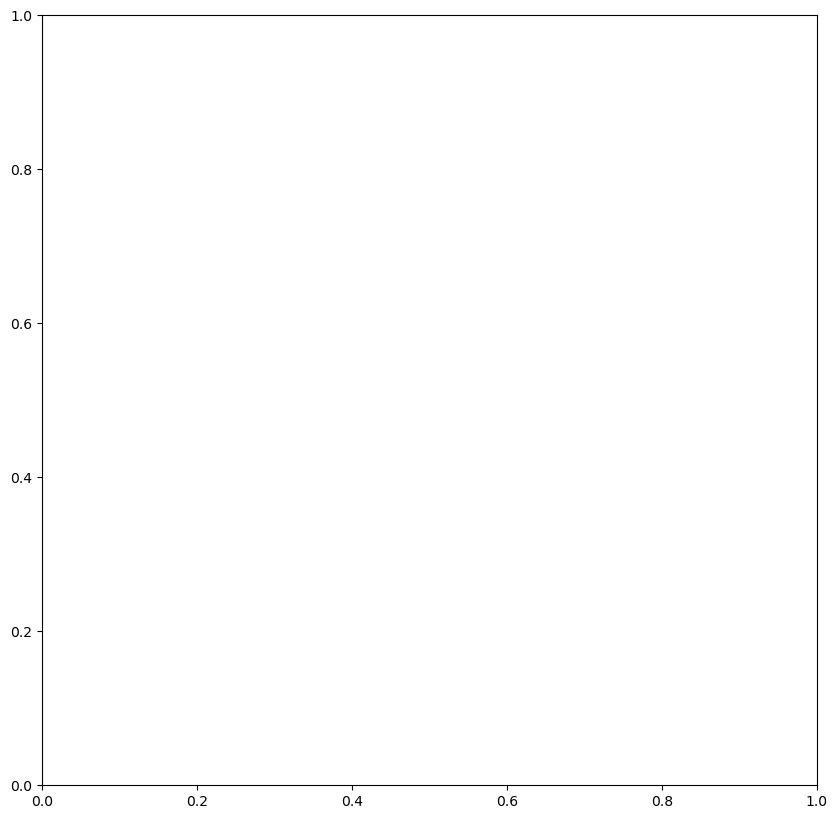

In [131]:
# visualizes the overlapping area
fig, ax = plt.subplots(figsize=(10, 10))
#source1.plot('geometry', ax=ax, edgecolor='black', facecolor='lightblue', alpha =0.7)
source2.plot(ax=ax, edgecolor='black', facecolor='lightcoral', alpha =0.7)
#intersection.plot(ax=ax, edgecolor='blue', facecolor='purple', alpha =0.8)

plt.show()

### <a id='toc1_2_1_'></a>[Find Other Relationships](#toc0_)

In [106]:
remaining = intersection[(duplicates_1 | duplicates_2)]
remaining

,id_1,source_1,id_2,source_2,geometry,area
1,B,1,H,2,"POLYGON ((5.00000 0.00000, 3.00000 0.00000, 3....",4.000
3,D,1,H,2,"POLYGON ((4.00000 2.50000, 3.00000 2.50000, 3....",1.250
4,J,1,H,2,"POLYGON ((4.50000 3.00000, 4.50000 3.75000, 5....",0.375


## <a id='toc1_2_1_'></a>[Overlapping Area](#toc0_)

In [ ]:
# Perform the intersection
intersection = gpd.overlay(g, g2, how='intersection', keep_geom_type=True)

# Calculate the area of the intersection
intersection['area'] = intersection.geometry.area

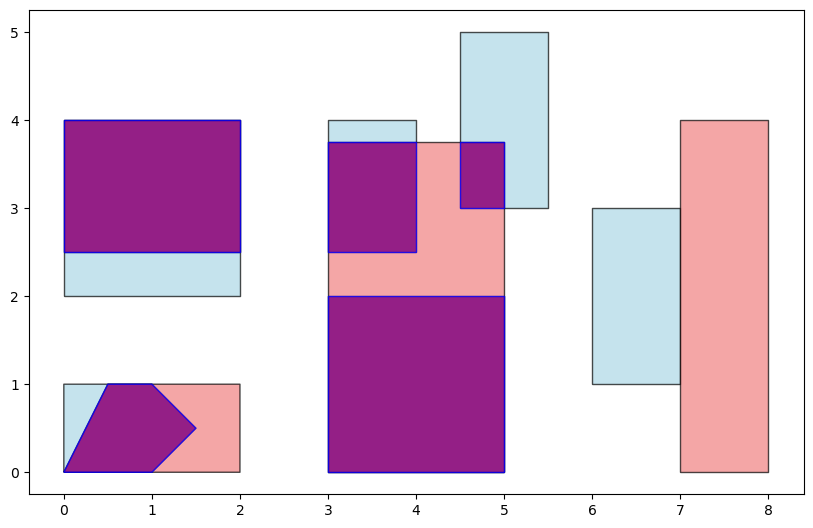

In [108]:
# visualizes the overlapping area
fig, ax = plt.subplots(figsize=(10, 10))
g.plot(ax=ax, edgecolor='black', facecolor='lightblue', alpha =0.7)
g2.plot(ax=ax, edgecolor='black', facecolor='lightcoral', alpha =0.7)
intersection.plot(ax=ax, edgecolor='blue', facecolor='purple', alpha =0.8)

plt.show()